In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
! pip install --quiet lightning
! pip install --quiet transformers

In [3]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import re
import string
from sklearn.model_selection import train_test_split
from transformers import XLNetTokenizer, XLNetForSequenceClassification, XLNetConfig
from torch.utils.data import DataLoader, Dataset
import torch
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import torchmetrics
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler

## XL Net with Meta Features

In [4]:
# Define the parameters to log with MLflow
params = {
    "train_path": "/content/gdrive/MyDrive/NUS_MSBA/BT5153_Final Group Project_Shared Folder/Data/train_preprocessed_v2.csv",
    "test_path": "/content/gdrive/MyDrive/NUS_MSBA/BT5153_Final Group Project_Shared Folder/Data/new_essay_val_preprocessed.csv",
    "test_path_dep": "/content/gdrive/MyDrive/NUS_MSBA/BT5153_Final Group Project_Shared Folder/Data/test_data_preprocessed.csv",
    "num_labels": 2,
    "batch_size": 6,
    "lr": 2e-5,
    "epochs": 3
}

In [5]:
#Loading preprocessed Train and Test Data
train_data_processed = pd.read_csv(params["train_path"])
test_data_processed = pd.read_csv(params["test_path"])
test_data_dep_processed = pd.read_csv(params["test_path_dep"])

In [6]:
display(train_data_processed)

,text,label,sentence_variation,%stop_word_total,mean_word_length,%adjectives_total
0,school homework clubs become increasingly popu...,1.0,5.291503,0.404908,5.398773,0.055215
1,widely accepted knowledge great source power s...,1.0,6.047842,0.459930,5.236934,0.111498
2,first impressions great power shape interactio...,1.0,9.306841,0.460784,5.250000,0.117647
3,name address city state zip code email address...,1.0,14.740441,0.408935,5.567010,0.096220
4,limiting car usage numerous advantages benefit...,1.0,6.080817,0.404959,5.524793,0.090909
...,...,...,...,...,...,...
28733,agathla peak agathlan mountain peak located we...,1.0,9.130170,0.449275,5.014493,0.043478
28734,hans schinz 6 december 1858 – 30 november 1915...,1.0,8.870957,0.366071,4.660714,0.035714
28735,pilgrimage route kii peninsula japan connectin...,1.0,3.696846,0.416000,4.976000,0.016000
28736,musica sacra magazine sacred music founded 197...,1.0,7.979263,0.424390,5.131707,0.121951


In [7]:
train_data_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28738 entries, 0 to 28737
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   text                28737 non-null  object 
 1   label               28738 non-null  float64
 2   sentence_variation  28738 non-null  float64
 3   %stop_word_total    28738 non-null  float64
 4   mean_word_length    28738 non-null  float64
 5   %adjectives_total   28738 non-null  float64
dtypes: float64(5), object(1)
memory usage: 1.3+ MB


In [8]:
test_data_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   text                40 non-null     object 
 1   label               40 non-null     int64  
 2   sentence_variation  40 non-null     float64
 3   %stop_word_total    40 non-null     float64
 4   mean_word_length    40 non-null     float64
 5   %adjectives_total   40 non-null     float64
dtypes: float64(4), int64(1), object(1)
memory usage: 2.0+ KB


In [9]:
test_data_dep_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   text                50 non-null     object 
 1   label               50 non-null     int64  
 2   sentence_variation  50 non-null     float64
 3   %stop_word_total    50 non-null     float64
 4   mean_word_length    50 non-null     float64
 5   %adjectives_total   50 non-null     float64
dtypes: float64(4), int64(1), object(1)
memory usage: 2.5+ KB


In [10]:
# Split the dataset
df_train, df_validation = train_test_split(train_data_processed, test_size=0.3, random_state=33)
df_test = test_data_processed
df_test_dep = test_data_dep_processed

# Drop NA values
df_train.dropna(inplace=True)
df_validation.dropna(inplace=True)
df_test.dropna(inplace=True)
df_test_dep.dropna(inplace=True)

In [11]:
# Tokenization and data preparation
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

In [12]:
# Define the XLNetDataset class with metafeatures
class XLNetDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=512):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

        meta_features = dataframe[['sentence_variation', '%stop_word_total', 'mean_word_length', '%adjectives_total']]
        self.scaler = StandardScaler()
        self.scaler.fit(meta_features)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        record = self.dataframe.iloc[idx]
        text = record['text']
        label = record['label']
        metafeatures = [
            record['sentence_variation'],
            record['%stop_word_total'],
            record['mean_word_length'],
            record['%adjectives_total']
        ]

        metafeatures = self.scaler.transform([metafeatures])[0]

        # Tokenize the text
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Extract input_ids and attention_mask
        input_ids = encoding['input_ids'].squeeze(0)
        attention_mask = encoding['attention_mask'].squeeze(0)
        metafeatures = torch.tensor(metafeatures, dtype=torch.float)

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'metafeatures': metafeatures,
            'label': torch.tensor(label, dtype=torch.long)
        }


In [13]:
# Create datasets and dataloaders
train_dataset = XLNetDataset(df_train, tokenizer)
val_dataset = XLNetDataset(df_validation, tokenizer)
test_dataset = XLNetDataset(df_test, tokenizer)
test_dep_dataset = XLNetDataset(df_test_dep, tokenizer)

train_loader = DataLoader(dataset=train_dataset, batch_size=params["batch_size"], shuffle=True, num_workers=4)
val_loader = DataLoader(dataset=val_dataset, batch_size=params["batch_size"], num_workers=4)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, num_workers=4)
test_loader_dep = DataLoader(dataset=test_dep_dataset, batch_size=1, num_workers=4)

In [14]:
class XLNetLightningModule(pl.LightningModule):
    def __init__(self, model_name, config, num_labels):
        super().__init__()
        # Initialize the XLNet model for sequence classification
        self.xlnet = XLNetForSequenceClassification.from_pretrained(model_name, config=config)

        self.meta_feature_processor = nn.Sequential(
            nn.Linear(4, 16),  # 4 metafeatures
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU()
        )
        # Classifier that uses combined XLNet features and metafeatures
        combined_features_dim = self.xlnet.config.hidden_size + 16  # Assuming the hidden size from XLNet and meta features
        self.classifier = nn.Linear(combined_features_dim, num_labels)

        # Define accuracy and AUROC metrics for training, validation, and testing
        self.train_acc = torchmetrics.classification.BinaryAccuracy()
        self.val_acc = torchmetrics.classification.BinaryAccuracy()
        self.test_acc = torchmetrics.classification.BinaryAccuracy()

        self.train_auroc = torchmetrics.classification.BinaryAUROC()
        self.val_auroc = torchmetrics.classification.BinaryAUROC()
        self.test_auroc = torchmetrics.classification.BinaryAUROC()


    def forward(self, input_ids, attention_mask, metafeatures):
        # Process inputs through XLNet model
        outputs = self.xlnet(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.hidden_states[-1]
        xlnet_features = last_hidden_state[:, 0, :]   # Get the features from the CLS token

        # Process metafeatures through the feed-forward network
        meta_features = self.meta_feature_processor(metafeatures)

        # Combine features from XLNet and metafeatures
        combined_features = torch.cat((xlnet_features, meta_features), dim=1)

        # Pass the combined features through the classifier
        logits = self.classifier(combined_features)
        return logits

    def training_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        metafeatures = batch['metafeatures']
        labels = batch['label']
        logits = self(input_ids, attention_mask, metafeatures)
        loss = F.cross_entropy(logits, labels)
        preds = torch.argmax(logits, dim=1)
        probs = torch.softmax(logits, dim=1)[:, 1]
        self.log('train_loss', loss, on_step=True, prog_bar=True)
        # self.log('train_acc', self.train_acc(preds, labels), on_step=True, prog_bar=True)
        # self.log('train_auroc', self.train_auroc(probs, labels), on_step=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        metafeatures = batch['metafeatures']
        labels = batch['label']
        logits = self(input_ids, attention_mask, metafeatures)
        loss = F.cross_entropy(logits, labels)
        preds = torch.argmax(logits, dim=1)
        probs = torch.softmax(logits, dim=1)[:, 1]
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        # self.log('val_acc', self.val_acc(preds, labels), on_epoch=True, prog_bar=True)
        # self.log('val_auroc', self.val_auroc(probs, labels), on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        metafeatures = batch['metafeatures']
        labels = batch['label']
        logits = self(input_ids, attention_mask, metafeatures)
        loss = F.cross_entropy(logits, labels)
        preds = torch.argmax(logits, dim=1)
        probs = torch.softmax(logits, dim=1)[:, 1]
        # self.log('test_loss', loss)
        self.log('test_acc', self.test_acc(preds, labels))
        self.log('test_auroc', self.test_auroc(probs, labels))
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=params["lr"])
        return optimizer

In [15]:
model_name = 'xlnet-base-cased'
num_labels=params["num_labels"]
config = XLNetConfig.from_pretrained(model_name, num_labels=num_labels, output_hidden_states=True)

lightning_module = XLNetLightningModule(model_name, config, num_labels)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lightning_module.to(device)

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLNetLightningModule(
  (xlnet): XLNetForSequenceClassification(
    (transformer): XLNetModel(
      (word_embedding): Embedding(32000, 768)
      (layer): ModuleList(
        (0-11): 12 x XLNetLayer(
          (rel_attn): XLNetRelativeAttention(
            (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (ff): XLNetFeedForward(
            (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (layer_1): Linear(in_features=768, out_features=3072, bias=True)
            (layer_2): Linear(in_features=3072, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (activation_function): GELUActivation()
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (sequence_summary): SequenceSummary(
      (summary): Linear(in_features=768, out_features=768, 

In [16]:
# Training setup
logger = TensorBoardLogger("xlnet_logs/", name="xl_net_train_v2_withmeta", version="train_v2_withmeata")
callbacks = [
    ModelCheckpoint(
        save_top_k=1,
        mode="min",
        monitor="val_loss"
    )  # save top 1 model
]

# Trainer configuration
trainer = pl.Trainer(
    max_epochs=params["epochs"],
    callbacks=callbacks,
    devices=1,
    logger=logger,
    log_every_n_steps=20,
)

trainer.fit(lightning_module, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                   | Type                           | Params
--------------------------------------------------------------------------
0 | xlnet                  | XLNetForSequenceClassification | 117 M 
1 | meta_feature_processor | Sequential                     | 352   
2 | classifier             | Linear                         | 1.6 K 
3 | train_acc              | BinaryAccuracy                 | 0     
4 | val_acc                | BinaryAccuracy                 | 0     
5 | test_acc               | BinaryAccuracy             

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


In [17]:
# Save the trained model after training
torch.save(lightning_module.state_dict(), '/content/gdrive/My Drive/NUS_MSBA/BT5153_Final Group Project_Shared Folder/XLnet_model_train_v2_withmeta.pth')

In [18]:
# load model
model_name = 'xlnet-base-cased'
num_labels=params["num_labels"]
config = XLNetConfig.from_pretrained(model_name, num_labels=num_labels, output_hidden_states=True)

model = XLNetLightningModule(model_name, config, num_labels)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.load_state_dict(torch.load('/content/gdrive/My Drive/NUS_MSBA/BT5153_Final Group Project_Shared Folder/XLnet_model_train_v2_withmeta.pth'))
model.to(device)
model.eval()

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLNetLightningModule(
  (xlnet): XLNetForSequenceClassification(
    (transformer): XLNetModel(
      (word_embedding): Embedding(32000, 768)
      (layer): ModuleList(
        (0-11): 12 x XLNetLayer(
          (rel_attn): XLNetRelativeAttention(
            (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (ff): XLNetFeedForward(
            (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (layer_1): Linear(in_features=768, out_features=3072, bias=True)
            (layer_2): Linear(in_features=3072, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (activation_function): GELUActivation()
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (sequence_summary): SequenceSummary(
      (summary): Linear(in_features=768, out_features=768, 

AUROC: 0.9550
Accuracy: 0.9250
Confusion Matrix:
[[18  2]
 [ 1 19]]


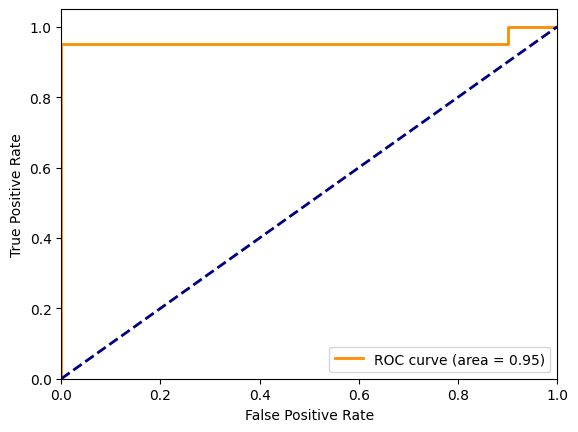

In [19]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def predict_and_evaluate(test_loader, model, device):
    model.eval()  # Set the model to evaluation mode
    true_labels = []
    predicted_probs = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            metafeatures = batch['metafeatures'].to(device)
            labels = batch['label'].to(device)

            logits = model(input_ids, attention_mask, metafeatures)

            probs = torch.softmax(logits, dim=1)[:, 1]  # get probability of the positive class

            true_labels.extend(labels.cpu().numpy())
            predicted_probs.extend(probs.cpu().numpy())

    # metrics
    auroc = roc_auc_score(true_labels, predicted_probs)
    accuracy = accuracy_score(true_labels, np.round(predicted_probs))
    fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)
    cm = confusion_matrix(true_labels, np.round(predicted_probs))

    print(f'AUROC: {auroc:.4f}')
    print(f'Accuracy: {accuracy:.4f}')
    print("Confusion Matrix:")
    print(cm)

    # calculate the AUROC
    roc_auc = auc(fpr, tpr)

    # plot the ROC curve
    plt.figure()
    lw = 2  # line width
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

predict_and_evaluate(test_loader, model, device)

AUROC: 0.7824
Accuracy: 0.6600
Confusion Matrix:
[[23  2]
 [15 10]]


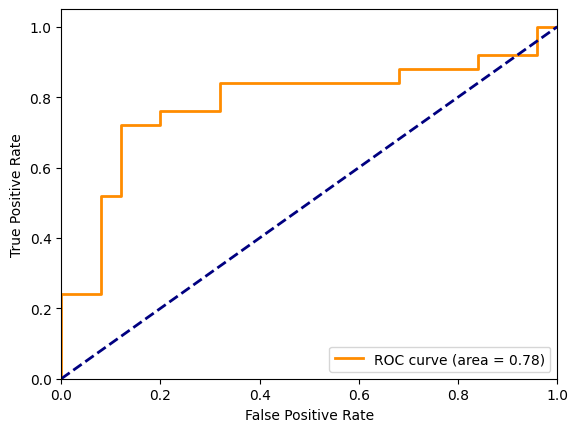

In [20]:
predict_and_evaluate(test_loader_dep, model, device)

AUROC: 0.9973
Accuracy: 0.9785
Confusion Matrix:
[[4194   89]
 [  96 4243]]


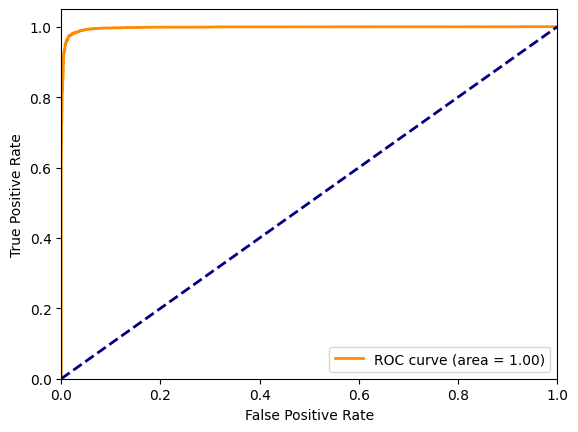

In [21]:
predict_and_evaluate(val_loader, model, device)

In [22]:
#Performance on validation dataset
trainer.test(lightning_module, dataloaders=val_loader, ckpt_path="best")

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at xlnet_logs/xl_net_train_v2_withmeta/train_v2_withmeata/checkpoints/epoch=2-step=10059.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at xlnet_logs/xl_net_train_v2_withmeta/train_v2_withmeata/checkpoints/epoch=2-step=10059.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9785432815551758     │
│        test_auroc         │    0.9684934616088867     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.9785432815551758, 'test_auroc': 0.9684934616088867}]

In [23]:
#Performance on test dataset
trainer.test(lightning_module, dataloaders=test_loader, ckpt_path="best")

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at xlnet_logs/xl_net_train_v2_withmeta/train_v2_withmeata/checkpoints/epoch=2-step=10059.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at xlnet_logs/xl_net_train_v2_withmeta/train_v2_withmeata/checkpoints/epoch=2-step=10059.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.925000011920929     │
│        test_auroc         │            0.0            │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.925000011920929, 'test_auroc': 0.0}]

In [24]:
#Performance on test dataset
trainer.test(lightning_module, dataloaders=test_loader_dep, ckpt_path="best")

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at xlnet_logs/xl_net_train_v2_withmeta/train_v2_withmeata/checkpoints/epoch=2-step=10059.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at xlnet_logs/xl_net_train_v2_withmeta/train_v2_withmeata/checkpoints/epoch=2-step=10059.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6599999666213989     │
│        test_auroc         │            0.0            │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.6599999666213989, 'test_auroc': 0.0}]

## Lime

In [25]:
!pip install --quiet lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [26]:
# load model
model_name = 'xlnet-base-cased'
num_labels=params["num_labels"]
config = XLNetConfig.from_pretrained(model_name, num_labels=num_labels, output_hidden_states=True)

model = XLNetLightningModule(model_name, config, num_labels)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.load_state_dict(torch.load('/content/gdrive/My Drive/NUS_MSBA/BT5153_Final Group Project_Shared Folder/XLnet_model_train_v2_withmeta.pth'))
model.to(device)
model.eval()

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLNetLightningModule(
  (xlnet): XLNetForSequenceClassification(
    (transformer): XLNetModel(
      (word_embedding): Embedding(32000, 768)
      (layer): ModuleList(
        (0-11): 12 x XLNetLayer(
          (rel_attn): XLNetRelativeAttention(
            (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (ff): XLNetFeedForward(
            (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (layer_1): Linear(in_features=768, out_features=3072, bias=True)
            (layer_2): Linear(in_features=3072, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (activation_function): GELUActivation()
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (sequence_summary): SequenceSummary(
      (summary): Linear(in_features=768, out_features=768, 

In [27]:
import lime
import lime.lime_text

# Step 1: Retrieve the specific instance of test data
test_instance = test_data_processed.iloc[33]

text_input = test_instance['text']
label = test_instance['label']  # the ground truth label for comparison

# Metafeatures from the test instance
unique_word_pct = float(test_instance['%unique_word_total'])
stop_word_pct = float(test_instance['%stop_word_total'])
mean_word_length = float(test_instance['mean_word_length'])
mean_char_count_per_word = float(test_instance['mean_char_count_per_word'])

# Step 2: Create a LIME explainer
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')  # Use the same tokenizer as in your model
explainer = lime.lime_text.LimeTextExplainer(class_names=['not AI-generated', 'AI-generated'])

# Step 3: Define the predict_proba function to predict probabilities using your model
def predict_proba(instances):
    batch_size = 1  # Adjust batch size based on available memory
    probabilities = []

    for i in range(0, len(instances), batch_size):
        batch_instances = instances[i:i+batch_size]
        batch_texts = [instance['text'] for instance in batch_instances]
        batch_metafeatures = [instance['metafeatures'] for instance in batch_instances]

        inputs = tokenizer(batch_texts, max_length=512, padding='max_length', truncation=True, return_tensors='pt')
        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)

        # Convert metafeatures to tensors
        metafeatures_tensor = torch.tensor(batch_metafeatures, dtype=torch.float).to(device)

        # Ensure model is also on the same device
        model.to(device)

        # Disable gradient calculation for inference
        with torch.no_grad():
            logits = model(input_ids, attention_mask, metafeatures_tensor)

            # Calculate probabilities using softmax
            batch_probabilities = torch.softmax(logits, dim=1).cpu().numpy()

        probabilities.extend(batch_probabilities)

    return np.array(probabilities)  # Convert to NumPy array for LIME compatibility

# Step 4: Generate LIME explanation
instances = [{'text': text_input, 'metafeatures': [unique_word_pct, stop_word_pct, mean_word_length, mean_char_count_per_word]}]

# Call predict_proba to obtain probabilities
probabilities = predict_proba(instances)

# Define the function to predict probabilities with LIME explainer
def lime_predict_proba(texts):
    return predict_proba([{'text': text, 'metafeatures': [unique_word_pct, stop_word_pct, mean_word_length, mean_char_count_per_word]} for text in texts])

# Create LIME explanation
explanation = explainer.explain_instance(text_input, lime_predict_proba, num_features=10, labels=[0, 1], top_labels=1)

KeyError: '%unique_word_total'

In [ ]:
# Step 5: Visualize the explanation
explanation.show_in_notebook(text=True)  # Display the explanation in a Jupyter notebook

# Optionally, print the predicted class, predicted probabilities, and ground truth label for comparison
predicted_label = np.argmax(probabilities)
predicted_class_name = explainer.class_names[predicted_label]

print(f"Predicted Class: {predicted_class_name}")
print(f"Predicted Probabilities: {probabilities}")
print(f"Ground Truth Label: {label}")

In [ ]:
# Model setup
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=params["num_labels"])

# LightningModule for training
class XLNetLightningModule(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.meta_feature_processor = nn.Sequential(
            nn.Linear(num_meta_features, 16),  # Example dimension
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU()
        )
        self.classifier = nn.Linear(self.model.config.hidden_size + 16, 2)
        self.train_acc = torchmetrics.Accuracy(task='binary')
        self.val_acc = torchmetrics.Accuracy(task='binary')
        self.test_acc = torchmetrics.Accuracy(task='binary')
        self.train_auroc = torchmetrics.AUROC(num_classes=params["num_labels"], task='binary')
        self.val_auroc = torchmetrics.AUROC(num_classes=params["num_labels"], task='binary')
        self.test_auroc = torchmetrics.AUROC(num_classes=params["num_labels"], task='binary')

    def forward(self, input_ids, attention_mask, metafeatures, labels=None):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits
        return logits, metafeatures

    def training_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        metafeatures = batch['metafeatures']
        labels = batch['label']
        logits, _ = self(input_ids, attention_mask, metafeatures, labels)
        loss = F.cross_entropy(logits, labels)
        preds = torch.argmax(logits, dim=1)
        self.train_acc(preds, labels)
        self.train_auroc(preds, labels)
        self.log('train_loss', loss)
        self.log('train_acc', self.train_acc, prog_bar=True)
        self.log('train_auroc', self.train_auroc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        metafeatures = batch['metafeatures']
        labels = batch['label']
        logits, _ = self(input_ids, attention_mask, metafeatures)
        loss = F.cross_entropy(logits, labels)
        preds = torch.argmax(logits, dim=1)
        self.val_acc(preds, labels)
        self.val_auroc(preds, labels)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', self.val_acc, prog_bar=True)
        self.log('val_auroc', self.val_auroc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        metafeatures = batch['metafeatures']
        labels = batch['label']
        logits, _ = self(input_ids, attention_mask, metafeatures)
        loss = F.cross_entropy(logits, labels)
        preds = torch.argmax(logits, dim=1)
        self.test_acc(preds, labels)
        self.test_auroc(preds, labels)
        self.log('test_loss', loss)
        self.log('test_acc', self.test_acc, prog_bar=True)
        self.log('test_auroc', self.test_auroc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=params["lr"])
        return optimizer

# Create LightningModule instance
lightning_module = XLNetLightningModule(model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lightning_module.to(device)

In [ ]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir xlnet_logs/